In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
import csv
import os
from pathlib import Path
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns
import spikeanal as spike

# It takes several steps to create the timestamp_dicts, refer to Ephys_Analysis_Notebook to create
timestamp_dicts = pickle.load(open('hpc_timestamp_dicts.pkl', 'rb'))

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'all_non_novel'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 96 is unsorted & has 5811 spikes
Unit 96 will be deleted
Unit 95 is unsorted & has 6458 spikes
Unit 95 will be deleted
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-4_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.r

In [2]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [3]:
# Create df of spike freq 10s before and 10s during every event
event_spikes = spike_analysis.generate_event_dataframe()

# Identify 'Pre-event' and 'Event' columns
pre_event_cols = [col for col in event_spikes.columns if col.startswith('Pre-event')]
event_cols = [col for col in event_spikes.columns if col.startswith('Event') and col not in ['Event name', 'Event number']]

# Create a new DataFrame by dropping the event_cols
pre_event_df = event_spikes.drop(columns=event_cols)

In [4]:
pre_event_df

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Pre-event timebin 91,Pre-event timebin 92,Pre-event timebin 93,Pre-event timebin 94,Pre-event timebin 95,Pre-event timebin 96,Pre-event timebin 97,Pre-event timebin 98,Pre-event timebin 99,Pre-event timebin 100
0,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,1,65,1.56,1.56,1.52,1.52,1.56,1.60,...,2.44,2.48,2.48,2.48,2.52,2.52,2.56,2.56,2.64,2.64
1,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,2,65,2.60,2.64,2.68,2.68,2.68,2.68,...,2.96,2.96,2.96,2.96,2.96,3.04,3.04,3.04,3.04,3.04
2,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,3,65,2.20,2.20,2.12,2.12,2.08,1.96,...,2.32,2.32,2.28,2.28,2.28,2.28,2.28,2.32,2.36,2.40
3,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,4,65,1.80,1.84,1.84,1.84,1.84,1.88,...,2.24,2.28,2.36,2.44,2.44,2.44,2.40,2.36,2.36,2.36
4,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,5,65,1.76,1.80,1.80,1.80,1.76,1.76,...,1.76,1.76,1.84,1.88,1.92,1.92,2.00,2.08,2.08,2.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,20230620_114347_standard_comp_to_omission_D4_s...,omission,4,100,0.80,0.80,0.80,0.80,0.80,0.80,...,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
10016,20230620_114347_standard_comp_to_omission_D4_s...,omission,1,2,0.56,0.52,0.52,0.52,0.44,0.44,...,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40
10017,20230620_114347_standard_comp_to_omission_D4_s...,omission,2,2,0.52,0.52,0.52,0.52,0.52,0.52,...,1.28,1.28,1.28,1.32,1.32,1.32,1.32,1.32,1.32,1.32
10018,20230620_114347_standard_comp_to_omission_D4_s...,omission,3,2,0.04,0.04,0.04,0.04,0.04,0.04,...,0.24,0.28,0.28,0.28,0.32,0.32,0.32,0.32,0.32,0.32


In [5]:
pre_event_mean = pre_event_df[pre_event_cols].mean(axis=1)
pre_event_std = pre_event_df[pre_event_cols].std(axis=1).round(3)
pre_event_variance = pre_event_df[pre_event_cols].std(axis=1).pow(2)

pre_event_fano = pre_event_variance / pre_event_mean
pre_event_fano = pre_event_fano.round(3)

pre_event_df

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Pre-event timebin 91,Pre-event timebin 92,Pre-event timebin 93,Pre-event timebin 94,Pre-event timebin 95,Pre-event timebin 96,Pre-event timebin 97,Pre-event timebin 98,Pre-event timebin 99,Pre-event timebin 100
0,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,1,65,1.56,1.56,1.52,1.52,1.56,1.60,...,2.44,2.48,2.48,2.48,2.52,2.52,2.56,2.56,2.64,2.64
1,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,2,65,2.60,2.64,2.68,2.68,2.68,2.68,...,2.96,2.96,2.96,2.96,2.96,3.04,3.04,3.04,3.04,3.04
2,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,3,65,2.20,2.20,2.12,2.12,2.08,1.96,...,2.32,2.32,2.28,2.28,2.28,2.28,2.28,2.32,2.36,2.40
3,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,4,65,1.80,1.84,1.84,1.84,1.84,1.88,...,2.24,2.28,2.36,2.44,2.44,2.44,2.40,2.36,2.36,2.36
4,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,5,65,1.76,1.80,1.80,1.80,1.76,1.76,...,1.76,1.76,1.84,1.88,1.92,1.92,2.00,2.08,2.08,2.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,20230620_114347_standard_comp_to_omission_D4_s...,omission,4,100,0.80,0.80,0.80,0.80,0.80,0.80,...,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
10016,20230620_114347_standard_comp_to_omission_D4_s...,omission,1,2,0.56,0.52,0.52,0.52,0.44,0.44,...,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40
10017,20230620_114347_standard_comp_to_omission_D4_s...,omission,2,2,0.52,0.52,0.52,0.52,0.52,0.52,...,1.28,1.28,1.28,1.32,1.32,1.32,1.32,1.32,1.32,1.32
10018,20230620_114347_standard_comp_to_omission_D4_s...,omission,3,2,0.04,0.04,0.04,0.04,0.04,0.04,...,0.24,0.28,0.28,0.28,0.32,0.32,0.32,0.32,0.32,0.32


In [6]:
pre_event_fano

0        0.053
1        0.009
2        0.009
3        0.021
4        0.014
         ...  
10015    0.004
10016    0.004
10017    0.122
10018    0.048
10019    0.040
Length: 10020, dtype: float64

In [7]:
# Calculate the average of the Fano factors
average_fano = pre_event_fano.mean()

# Calculate the standard deviation of the Fano factors
std_fano = pre_event_fano.std()

# Print the results
print("Average Fano Factor:", average_fano)
print("Standard Deviation of Fano Factor:", std_fano)

Average Fano Factor: 0.03948263784649254
Standard Deviation of Fano Factor: 0.09824097594817957


In [8]:
# Define the directory path
test_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'all_non_novel' / '20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec' / 'phy'

# Define the full file path
file_path = test_path / 'spike_clusters.npy'

# Load the file
t1_spike_clusters = np.load(file_path)

In [9]:
t1_spike_clusters

array([85, 41, 55, ..., 14, 26, 87], dtype=int32)

In [10]:
len(t1_spike_clusters)

483418

In [11]:
file_path = test_path / 'spike_times.npy'
t1_spike_times = np.load(file_path)

In [12]:
t1_spike_times

array([[     689],
       [    1754],
       [    1829],
       ...,
       [68293021],
       [68293168],
       [68293331]])

In [13]:
len(t1_spike_times)

483418

In [14]:
file_path = test_path / 'cluster_group.tsv'
t1_cluster_group = pd.read_csv(file_path, delimiter='\t')

In [15]:
t1_cluster_group

,cluster_id,group
0,1,noise
1,2,good
2,3,noise
3,5,good
4,9,unsorted
5,11,noise
6,12,noise
7,13,good
8,14,noise
9,17,good


In [16]:
with open(os.path.join(file_path), "r") as f:
            reader = csv.DictReader(f, delimiter="\t")
            labels_dict = {row["cluster_id"]: row["group"] for row in reader}

In [17]:
spikes_to_delete = []
unsorted_clusters = {}
for spikei in range(len(t1_spike_times)):
    try:
        if labels_dict[t1_spike_clusters[spikei].astype(str)] == "noise":
            spikes_to_delete.append(spikei)
    except KeyError:
        spikes_to_delete.append(spikei)
        if t1_spike_clusters[spikei] in unsorted_clusters.keys():
            total_spikes = unsorted_clusters[t1_spike_clusters[spikei]]
            total_spikes = total_spikes + 1
            unsorted_clusters[t1_spike_clusters[spikei]] = total_spikes
        else:
            unsorted_clusters[t1_spike_clusters[spikei]] = 1
for unit, no_spike in unsorted_clusters.items():
    print(
        f"Unit {unit} is unsorted & has {no_spike} spikes"
    )
    print(
        f"Unit {unit} will be deleted"
    )
t2_spike_times = np.delete(t1_spike_times, spikes_to_delete)
t2_spike_clusters = np.delete(t1_spike_clusters, spikes_to_delete)

In [18]:
t2_spike_times

array([     689,     1829,     2935, ..., 68292947, 68292976, 68293168])

In [19]:
t2_spike_clusters

array([85, 55, 58, ..., 19, 35, 26], dtype=int32)

In [20]:
len(t2_spike_clusters)

380690

In [21]:
# Create a DataFrame from the spike times and spike clusters
df = pd.DataFrame({
    'spike_times': t2_spike_times,
    'cluster_id': t2_spike_clusters
})

# Sort by cluster_id and spike_times to ensure correct ISI calculation
df = df.sort_values(by=['cluster_id', 'spike_times'])

In [22]:
df

,spike_times,cluster_id
25,6952,2
28,8664,2
30,9476,2
48,13990,2
51,14563,2
...,...,...
379803,68166217,98
379826,68169845,98
379957,68187930,98
380000,68196317,98


In [23]:
# Calculate ISIs within each cluster
df['ISI'] = df.groupby('cluster_id')['spike_times'].diff()

# Remove NaN values that appear for the first spike of each cluster
df = df.dropna(subset=['ISI'])

In [24]:
df

,spike_times,cluster_id,ISI
28,8664,2,1712.0
30,9476,2,812.0
48,13990,2,4514.0
51,14563,2,573.0
55,15486,2,923.0
...,...,...,...
379803,68166217,98,6475.0
379826,68169845,98,3628.0
379957,68187930,98,18085.0
380000,68196317,98,8387.0


In [25]:
# Group by cluster and calculate variance and mean of ISIs
isi_stats = df.groupby('cluster_id')['ISI'].agg(['mean', 'var'])

# Calculate Fano Factor: Variance / Mean^2
isi_stats['Fano_Factor'] = isi_stats['var'] / isi_stats['mean'] ** 2

In [26]:
print(isi_stats[['Fano_Factor']])

            Fano_Factor
cluster_id             
2              2.093009
5              9.277811
9              2.648814
13             2.179002
17             8.792940
18             6.654221
19             2.895727
22             3.404443
23             4.241455
24             9.331529
26             3.047322
29             6.012176
30             1.961002
31             2.855742
33             2.640574
34             1.993638
35             1.551222
36            16.327364
38             1.403351
39             4.705207
44             2.070270
53             2.052605
55             1.068990
56             2.182715
57            17.630132
58             1.570316
59             2.628770
65            15.637905
68             5.735348
81             3.391964
82             2.796190
85             9.379930
88             1.530557
94             1.519750
98             7.482657


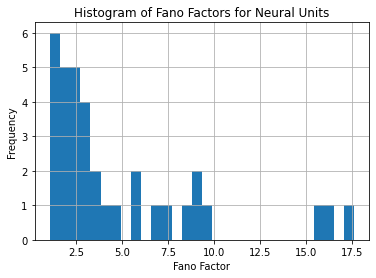

In [27]:
# Histogram of Fano Factors
isi_stats['Fano_Factor'].hist(bins=30)
plt.title('Histogram of Fano Factors for Neural Units')
plt.xlabel('Fano Factor')
plt.ylabel('Frequency')
plt.show()

In [28]:
# Example: Calculating Fano Factor using consistent time bins
time_bins = np.arange(0, max(t2_spike_times), 1000)  # 1-second bins if times are in milliseconds
spike_counts = np.histogram(t2_spike_times, bins=time_bins)[0]
fano_factor = np.var(spike_counts) / np.mean(spike_counts)

In [29]:
fano_factor

1.5212200619434442

In [30]:
time_bins

array([       0,     1000,     2000, ..., 68291000, 68292000, 68293000])

In [31]:
spike_counts

array([1, 1, 1, ..., 3, 9, 8])

In [32]:
# Calculate the mean and variance of spike counts across time bins for each row
pre_event_df['mean_spikes'] = pre_event_df[pre_event_cols].mean(axis=1)
pre_event_df['variance_spikes'] = pre_event_df[pre_event_cols].var(axis=1)

# Display the DataFrame to check the newly added columns
print(pre_event_df[['mean_spikes', 'variance_spikes']])

       mean_spikes  variance_spikes
0           1.8860         0.099180
1           2.8084         0.026288
2           2.1504         0.019204
3           2.0696         0.044400
4           1.5936         0.022908
...            ...              ...
10015       0.7456         0.002667
10016       0.4368         0.001670
10017       0.7204         0.088097
10018       0.1752         0.008332
10019       0.2488         0.010039

[10020 rows x 2 columns]


In [33]:
# Calculate the Fano Factor for each neuron or recording session
pre_event_df['Fano_Factor'] = pre_event_df['variance_spikes'] / pre_event_df['mean_spikes']

# Display the Fano Factor column
print(pre_event_df[['Fano_Factor']])

       Fano_Factor
0         0.052587
1         0.009361
2         0.008930
3         0.021453
4         0.014375
...            ...
10015     0.003577
10016     0.003824
10017     0.122289
10018     0.047559
10019     0.040349

[10020 rows x 1 columns]


count    9.993000e+03
mean     3.948199e-02
std      9.824319e-02
min      1.945384e-32
25%      4.196807e-03
50%      1.087638e-02
75%      3.142410e-02
max      1.748258e+00
Name: Fano_Factor, dtype: float64


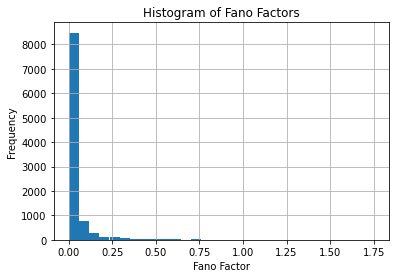

In [34]:
# Descriptive statistics for Fano Factor
print(pre_event_df['Fano_Factor'].describe())

# Histogram of Fano Factors
pre_event_df['Fano_Factor'].hist(bins=30)
plt.title('Histogram of Fano Factors')
plt.xlabel('Fano Factor')
plt.ylabel('Frequency')
plt.show()

In [35]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 5, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [37]:
# Create df of spike freq 10s before and 10s during every event
event_spikes = spike_analysis.generate_event_dataframe()

# Identify 'Pre-event' and 'Event' columns
pre_event_cols = [col for col in event_spikes.columns if col.startswith('Pre-event')]
event_cols = [col for col in event_spikes.columns if col.startswith('Event') and col not in ['Event name', 'Event number']]

# Create a new DataFrame by dropping the event_cols
pre_event_df = event_spikes.drop(columns=event_cols)

In [38]:
pre_event_mean = pre_event_df[pre_event_cols].mean(axis=1)
pre_event_std = pre_event_df[pre_event_cols].std(axis=1).round(3)
pre_event_variance = pre_event_df[pre_event_cols].std(axis=1).pow(2)

pre_event_fano = pre_event_variance / pre_event_mean
pre_event_fano = pre_event_fano.round(3)

pre_event_df

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Pre-event timebin 1991,Pre-event timebin 1992,Pre-event timebin 1993,Pre-event timebin 1994,Pre-event timebin 1995,Pre-event timebin 1996,Pre-event timebin 1997,Pre-event timebin 1998,Pre-event timebin 1999,Pre-event timebin 2000
0,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,1,65,1.6,1.6,1.6,1.6,0.8,0.8,...,2.4,2.4,2.4,3.2,3.2,3.2,3.2,3.2,3.2,3.2
1,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,2,65,0.8,0.8,0.8,0.8,0.8,0.8,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8
2,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,3,65,0.8,0.8,0.8,0.8,0.8,0.8,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8
3,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,4,65,0.8,0.8,0.8,0.8,0.8,0.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20230618_100636_standard_comp_to_omission_D2_s...,rewarded,5,65,0.8,0.8,0.8,0.8,0.8,0.8,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,20230620_114347_standard_comp_to_omission_D4_s...,omission,4,100,1.6,1.6,1.6,1.6,1.6,1.6,...,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2
10016,20230620_114347_standard_comp_to_omission_D4_s...,omission,1,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10017,20230620_114347_standard_comp_to_omission_D4_s...,omission,2,2,0.8,0.8,0.8,0.8,0.8,0.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10018,20230620_114347_standard_comp_to_omission_D4_s...,omission,3,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
pre_event_fano

0        1.015
1        2.038
2        1.473
3        1.214
4        0.469
         ...  
10015    0.694
10016    2.038
10017    0.748
10018    0.700
10019    1.119
Length: 10020, dtype: float64

In [40]:
# Calculate the average of the Fano factors
average_fano = pre_event_fano.mean()

# Calculate the standard deviation of the Fano factors
std_fano = pre_event_fano.std()

# Print the results
print("Average Fano Factor:", average_fano)
print("Standard Deviation of Fano Factor:", std_fano)

Average Fano Factor: 1.2041466625207298
Standard Deviation of Fano Factor: 0.9929288680795216


In [41]:
event_mean = event_spikes[event_cols].mean(axis=1)
event_std = event_spikes[event_cols].std(axis=1).round(3)
event_variance = event_spikes[event_cols].std(axis=1).pow(2)

event_fano = event_variance / event_mean
event_fano = event_fano.round(3)

event_fano

0        1.080
1        0.714
2        1.064
3        1.127
4        0.586
         ...  
10015    1.806
10016    0.679
10017    2.736
10018    0.915
10019    1.692
Length: 10020, dtype: float64

In [42]:
# Calculate the average of the Fano factors
average_fano = event_fano.mean()

# Calculate the standard deviation of the Fano factors
std_fano = event_fano.std()

# Print the results
print("Average Fano Factor:", average_fano)
print("Standard Deviation of Fano Factor:", std_fano)

Average Fano Factor: 1.4650179653013038
Standard Deviation of Fano Factor: 1.615298526895692


In [43]:
pre_event_fano_nadrops = pre_event_fano.dropna()

In [44]:
pre_event_fano_nadrops

0        1.015
1        2.038
2        1.473
3        1.214
4        0.469
         ...  
10015    0.694
10016    2.038
10017    0.748
10018    0.700
10019    1.119
Length: 9648, dtype: float64

In [45]:
def analyze_firing_rates(df):
    # Define pre-event and event column names based on your description
    pre_event_cols = [col for col in event_spikes.columns if col.startswith('Pre-event')]
    event_cols = [col for col in event_spikes.columns if col.startswith('Event') and col not in ['Event name', 'Event number']]

    # Calculate mean firing rates before and after the event
    df['mean_pre_event'] = df[pre_event_cols].mean(axis=1)
    df['mean_event'] = df[event_cols].mean(axis=1)

    # Difference in firing rates
    df['diff_firing_rate'] = df['mean_event'] - df['mean_pre_event']

    # Bootstrap to assess the significance of the difference
    # We use a simple bootstrap here for the mean difference, but you can extend this
    results = []
    for i in range(1000):  # number of bootstrap samples
        sampled = df.sample(n=len(df), replace=True)
        mean_diff = sampled['mean_event'].mean() - sampled['mean_pre_event'].mean()
        results.append(mean_diff)

    # Calculate a 95% confidence interval from the bootstrap distribution
    ci_lower = np.percentile(results, 2.5)
    ci_upper = np.percentile(results, 97.5)

    return df, (ci_lower, ci_upper)

In [46]:
results_df, confidence_interval = analyze_firing_rates(event_spikes)
print("95% Confidence interval for mean differences:", confidence_interval)

95% Confidence interval for mean differences: (-0.12718882634730422, -0.030705301397205863)


In [47]:
def analyze_firing_rates2(df):
    # Dynamically define pre-event and event column names based on the DataFrame
    pre_event_cols = [col for col in df.columns if col.startswith('Pre-event')]
    event_cols = [col for col in df.columns if col.startswith('Event') and col not in ['Event name', 'Event number']]

    # Calculate mean firing rates before and after the event
    df['mean_pre_event'] = df[pre_event_cols].mean(axis=1)
    df['mean_event'] = df[event_cols].mean(axis=1)

    # Difference in firing rates
    df['diff_firing_rate'] = df['mean_event'] - df['mean_pre_event']

    # Define a function to calculate the mean difference from resampled data
    def mean_diff(data, axis=None):
        # data is expected to be 2D: rows are resamples, columns are [mean_pre_event, mean_event]
        # Compute mean difference along the specified axis
        return np.mean(data[:, 1] - data[:, 0], axis=axis)

    # Create an array of the data to be bootstrapped
    data = df[['mean_pre_event', 'mean_event']].to_numpy()

    # Ensure the data is 2-dimensional
    if data.ndim != 2 or data.shape[1] != 2:
        raise ValueError("Data array must be 2-dimensional with two columns.")

    # Using the bootstrap function to calculate the confidence interval
    res = bootstrap((data,), mean_diff, vectorized=True,
                    n_resamples=1000, method='percentile', confidence_level=0.95)

    # Extract the confidence interval
    confidence_interval = res.confidence_interval

    return df, confidence_interval

# Assuming 'event_spikes' is your DataFrame loaded with the appropriate data
results_df, confidence_interval = analyze_firing_rates2(event_spikes)
print("95% Confidence interval for mean differences:", confidence_interval)

95% Confidence interval for mean differences: ConfidenceInterval(low=-0.0891861946107783, high=-0.06012745808383143)


In [48]:
def mean_diff(data, axis=None):
    return np.mean(data[:, 1] - data[:, 0], axis=axis)

def analyze_group(df):
    # Calculate mean firing rates before and after the event
    pre_event_cols = [col for col in df.columns if col.startswith('Pre-event')]
    event_cols = [col for col in df.columns if col.startswith('Event') and col not in ['Event name', 'Event number']]
    df['mean_pre_event'] = df[pre_event_cols].mean(axis=1)
    df['mean_event'] = df[event_cols].mean(axis=1)
    data = df[['mean_pre_event', 'mean_event']].to_numpy()

    # Bootstrap analysis to get the confidence interval
    res = bootstrap((data,), mean_diff, vectorized=True, n_resamples=1000, method='percentile', confidence_level=0.95)
    
    return {
        'low': res.confidence_interval.low,
        'high': res.confidence_interval.high,
        'significant': not (res.confidence_interval.low <= 0 <= res.confidence_interval.high)
    }

# Group data by 'Recording', 'Event name', and 'Unit number'
grouped = event_spikes.groupby(['Recording', 'Event name', 'Unit number'])

# Apply analysis to each group
results = grouped.apply(analyze_group)

# Results will be a DataFrame with a MultiIndex (Recording, Event name, Unit number)
print(results)

Recording                                                                         Event name  Unit number
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec       lose        2              {'low': -0.4532671428571393, 'high': -0.399361...
                                                                                              5              {'low': -0.08250000000000071, 'high': 0.039642...
                                                                                              13             {'low': 0.07760428571429107, 'high': 0.4251957...
                                                                                              17             {'low': 0.11763714285714348, 'high': 0.2449914...
                                                                                              19             {'low': 0.06993285714285431, 'high': 0.6384671...
                                                                                                   

In [49]:
# Assuming 'results' has already been computed:
results_df = results.reset_index()

In [50]:
# Make sure the results from 'analyze_group' are flattened into separate columns
results_df = results_df.join(pd.DataFrame(results_df.pop(0).tolist()))

In [51]:
# Assuming 'results_df' has a column named 'significant' which contains Boolean values
true_false_counts = results_df['significant'].value_counts()

true_false_counts

significant
True     514
False    288
Name: count, dtype: int64

## Needed to restart the Kernel and close other applications in order to have enough memory to run the next step

In [52]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 1, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


## Still didn't have enough memory for this step

In [53]:
# Create df of spike freq 10s before and 10s during every event
event_spikes = spike_analysis.generate_event_dataframe()

# Identify 'Pre-event' and 'Event' columns
pre_event_cols = [col for col in event_spikes.columns if col.startswith('Pre-event')]
event_cols = [col for col in event_spikes.columns if col.startswith('Event') and col not in ['Event name', 'Event number']]

In [54]:
pre_event_mean = event_spikes[pre_event_cols].mean(axis=1)
pre_event_std = event_spikes[pre_event_cols].std(axis=1).round(3)
pre_event_variance = event_spikes[pre_event_cols].std(axis=1).pow(2)
pre_event_fano = pre_event_variance / pre_event_mean
pre_event_fano = pre_event_fano.round(3)

event_mean = event_spikes[event_cols].mean(axis=1)
event_std = event_spikes[event_cols].std(axis=1).round(3)
event_variance = event_spikes[event_cols].std(axis=1).pow(2)
event_fano = event_variance / event_mean
event_fano = event_fano.round(3)

# Calculate the average of the Fano factors
pre_average_fano = pre_event_fano.mean()
average_fano = event_fano.mean()

# Calculate the standard deviation of the Fano factors
pre_std_fano = pre_event_fano.std()
std_fano = event_fano.std()

# Print the results
print("Average Pre-event Fano Factor:", pre_average_fano)
print("SD of Pre-event Fano Factor:", pre_std_fano)

print("Average Event Fano Factor:", average_fano)
print("SD Event of Fano Factor:", std_fano)

Average Pre-event Fano Factor: 4.619154342845242
SD of Pre-event Fano Factor: 2.0426273943999917
Average Event Fano Factor: 4.829057991951296
SD Event of Fano Factor: 2.36867887897965
